In [1]:
cd ..

/work


# Lecture dataset

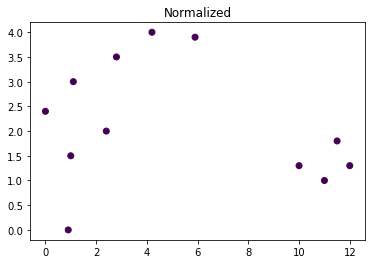

In [4]:
import pandas as pd
from src.datasets import Dataset
from src.utils import *
from src.clusterization_performance import *

dataset = Dataset('./data/lecture_dataset.txt') 
X, y = dataset.X, dataset.y
df = pd.read_csv("./out/dbscan_cpp_lecture_dataset.csv", header=None)
y_pred, state = df[0], df[1]
display_points(X, y_pred, 'Normalized', numerate=False)

## OUT

In [5]:
pd.options.display.max_rows = None
name = 'dbscan_cpp_lecture_dataset_D2_R12_m4_e2_euclidean_distance'

logs = pd.read_csv(
    f'out/LOG_{name}.log',
    names=['time [ms]', 'operation', 'point_id', 'value', 'string'],
    index_col=False
)
logs['time [ms]'] -= logs['time [ms]'].min()
logs.head()

,time [ms],operation,point_id,value,string
0,0.0,reading_data,NaN,0.00604,NaN


In [6]:
import time 
import numpy as np

timer_start = time.time()
# logs = algorithm.get_logs()
mask = logs['operation'] == 'similarity_calculation'
similarity_calculation = logs[mask].groupby('point_id').sum().reset_index().drop(columns=['time [ms]'])
similarity_calculation.rename(columns={'value': '# of distance/similarity calculations'}, inplace=True)

out = pd.DataFrame({
    'point_id': np.arange(dataset.n_rows),
    'x': dataset.X[:, 0], 
    'y': dataset.X[:, 1],
    'point_type': state, # 1 - core, 0 - border, -1 - noise
    'CId': y_pred # clusters: cluster identifier or -1 in the case of noise points
})

out = out.merge(similarity_calculation, on='point_id')
out.to_csv(f'./out/OUT_{name}.csv', index=False)
saving_OUT_time = (time.time() - timer_start) * 1000
out.head()

,point_id,x,y,point_type,CId,# of distance/similarity calculations,string


## STAT

In [7]:
params = {
    'epsilon': 2,
    'minPts': 3,
    'similarity': 'euclidean_distance'
}

score = evaluate(y_pred, dataset.y, dataset.X)

In [108]:
timer_stat = time.time()
stat = pd.DataFrame({
    'name of the input fil': dataset.name,
    '# of dimensions of a point': dataset.n_dimentions,
    '# of points in the input file': dataset.n_rows,
    'epsilon': params['epsilon'] if 'epsilon' in params else '',
    'minPts': params['minPts'] if 'minPts' in params else '',
    'k':  params['k'] if 'k' in params else '',
    'similarity': params['similarity'],
    'values of dimensions of a reference point': '[0,1]',
    'reading the input file [ms]': logs.loc[logs['operation'] == 'reading_data', 'value'].values[0] * 1000,
    'normalization of vectors [ms]': "",
    "Eps-neighborhood timer [ms]": logs.loc[logs['operation'] == 'Eps_time', 'value'].sum() * 1000,
    'Clustering timer [ms]': (
        logs.loc[logs['operation'] == 'stop log', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'start log', 'time [ms]'].values[0]
    ) * 1000,
    'saving results to OUT time [ms]': logs.loc[logs['operation'] == 'writing_data', 'value'].values[0] * 1000,
    "dist_to_ref_point_time [ms]": logs[logs['operation'] == 'dist_to_ref_point_time']['value'].sum() * 1000,
    'total runtime [ms]': (
        logs.loc[logs['operation'] == 'writing_data', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'reading_data', 'time [ms]'].values[0]
    ) * 1000,
    "sorting_dist_time [ms]": logs[logs['operation'] == 'sorting_pessimistic_est_time']['value'].sum() * 1000,
    "tiknn_time [ms]": logs[logs['operation'] == 'tiknn_time']['value'].sum() * 1000,
    "tirnn_time [ms]": logs[logs['operation'] == 'tirnn_time']['value'].sum() * 1000,
    '# of discovered clusters': sum(out['CId'] > -1),
    '# of discovered noise points': sum(out['point_type'] == -1),
    '# of discovered core points': sum(out['point_type'] == 1),
    '# of discovered border points': sum(out['point_type'] == 0),
    'avg # of calculations of distance/similarity': out['# of distance/similarity calculations'].mean(),
    '|TP|': score['TP'],
    '|TN|': score['TN'],
    '# of pairs of points': len(y),
    'RAND': score['rand_score'],
    'Purity': score['purity'],
    'Silhouette coefficient': score['silhouette_score_euclidean'],
    'Davies Bouldin': score['davies_bouldin_score']
}, index=['values']).T
stat_time = time.time() - timer_stat
print(stat_time)
stat.to_csv(f'./out/STAT_{name}.csv', index=False)
stat

0.012345552444458008


,values
name of the input fil,lecture_dataset
# of dimensions of a point,2
# of points in the input file,12
epsilon,2
minPts,3
k,
similarity,euclidean_distance
values of dimensions of a reference point,"[0,1]"
reading the input file [ms],2.8123
normalization of vectors [ms],


## DEBUG

In [109]:
mask1 = logs['operation'] == '|Eps_neighbors|'
mask2 = logs['operation'] == 'Eps_neighbor_id'

debug1 = (
    logs[mask1]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug1.reset_index(col_level=1, inplace=True)
debug1.columns.name = None

debug2 = (
    logs[mask2]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug2.reset_index(col_level=1, inplace=True)
debug2.columns.name = None

debug = debug1.merge(debug2, on='point_id')
debug.to_csv(f'./out/DEBUG_{name}.csv', index=False)
debug

,point_id,|Eps_neighbors|,Eps_neighbor_id
0,0.0,3.0,0;1;2; 0;1;2;
1,1.0,2.0,0;1;
2,2.0,4.0,0;2;5;7;
3,3.0,4.0,3;4;8;9;
4,4.0,4.0,3;4;8;9;
5,5.0,5.0,2;5;6;7;11;
6,6.0,3.0,5;6;11; 5;6;11;
7,7.0,4.0,2;5;7;11;
8,8.0,4.0,3;4;8;9;
9,9.0,4.0,3;4;8;9;


# Compound dataset

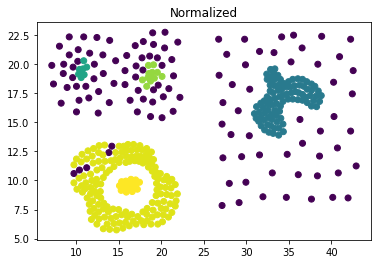

In [110]:
import pandas as pd
from src.datasets import Dataset
from src.utils import *
from src.clusterization_performance import *

dataset = Dataset('./data/compound_dataset.txt') 
X, y = dataset.X, dataset.y
df = pd.read_csv("./out/dbscan_cpp_compound_dataset.csv", header=None)
y_pred, state = df[0], df[1]
display_points(X, y_pred, 'Normalized', numerate=False)

## OUT

In [111]:
x= pd.read_csv(f'out/LOG_{name}.log')
x.head()

,1644519064.22058,reading_data,Unnamed: 2,0.0028123,Unnamed: 4
0,1.644519e+09,start log,NaN,NaN,NaN
1,1.644519e+09,similarity_calculation,0.0,1.0,NaN
2,1.644519e+09,similarity_calculation,0.0,1.0,NaN
3,1.644519e+09,similarity_calculation,0.0,1.0,NaN
4,1.644519e+09,similarity_calculation,0.0,1.0,NaN


In [112]:
pd.options.display.max_rows = None
name = 'dbscan_cpp_compound_dataset_D2_R399_m3_e0.7_euclidean_distance'

logs = pd.read_csv(
    f'out/LOG_{name}.log',
    names=['time [ms]', 'operation', 'point_id', 'value', 'string'],
    index_col=False
)
logs['time [ms]'] -= logs['time [ms]'].min()
logs.head()

,time [ms],operation,point_id,value,string
0,0.000000,reading_data,NaN,0.003607,NaN
1,0.998448,start log,NaN,NaN,NaN
2,1.001044,similarity_calculation,0.0,1.000000,NaN
3,1.001366,similarity_calculation,0.0,1.000000,NaN
4,1.001797,similarity_calculation,0.0,1.000000,NaN


In [113]:
import time 
import numpy as np

timer_start = time.time()
# logs = algorithm.get_logs()
mask = logs['operation'] == 'similarity_calculation'
similarity_calculation = logs[mask].groupby('point_id').sum().reset_index().drop(columns=['time [ms]'])
similarity_calculation.rename(columns={'value': '# of distance/similarity calculations'}, inplace=True)

out = pd.DataFrame({
    'point_id': np.arange(dataset.n_rows),
    'x': dataset.X[:, 0], 
    'y': dataset.X[:, 1],
    'point_type': state, # 1 - core, 0 - border, -1 - noise
    'CId': y_pred # clusters: cluster identifier or -1 in the case of noise points
})

out = out.merge(similarity_calculation, on='point_id')
out.to_csv(f'./out/OUT_{name}.csv', index=False)
saving_OUT_time = (time.time() - timer_start) * 1000
out.head()

,point_id,x,y,point_type,CId,# of distance/similarity calculations
0,0,26.75,22.15,0,-1,399.0
1,1,29.80,22.15,0,-1,399.0
2,2,31.55,21.10,0,-1,399.0
3,3,27.70,20.85,0,-1,399.0
4,4,29.90,19.95,0,-1,399.0


## STAT

In [114]:
params = {
    'epsilon': 0.7,
    'minPts': 3,
    'similarity': 'euclidean_distance'
}

score = evaluate(y_pred, dataset.y, dataset.X)

In [115]:
timer_stat = time.time()
stat = pd.DataFrame({
    'name of the input fil': dataset.name,
    '# of dimensions of a point': dataset.n_dimentions,
    '# of points in the input file': dataset.n_rows,
    'epsilon': params['epsilon'] if 'epsilon' in params else '',
    'minPts': params['minPts'] if 'minPts' in params else '',
    'k':  params['k'] if 'k' in params else '',
    'similarity': params['similarity'],
    'values of dimensions of a reference point': '[0,1]',
    'reading the input file [ms]': logs.loc[logs['operation'] == 'reading_data', 'value'].values[0] * 1000,
    'normalization of vectors [ms]': "",
    "Eps-neighborhood timer [ms]": logs.loc[logs['operation'] == 'Eps_time', 'value'].sum() * 1000,
    'Clustering timer [ms]': (
        logs.loc[logs['operation'] == 'stop log', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'start log', 'time [ms]'].values[0]
    ) * 1000,
    'saving results to OUT time [ms]': logs.loc[logs['operation'] == 'writing_data', 'value'].values[0] * 1000,
    "dist_to_ref_point_time [ms]": logs[logs['operation'] == 'dist_to_ref_point_time']['value'].sum() * 1000,
    'total runtime [ms]': (
        logs.loc[logs['operation'] == 'writing_data', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'reading_data', 'time [ms]'].values[0]
    ) * 1000,
    "sorting_dist_time [ms]": logs[logs['operation'] == 'sorting_pessimistic_est_time']['value'].sum() * 1000,
    "tiknn_time [ms]": logs[logs['operation'] == 'tiknn_time']['value'].sum() * 1000,
    "tirnn_time [ms]": logs[logs['operation'] == 'tirnn_time']['value'].sum() * 1000,
    '# of discovered clusters': sum(out['CId'] > -1),
    '# of discovered noise points': sum(out['point_type'] == -1),
    '# of discovered core points': sum(out['point_type'] == 1),
    '# of discovered border points': sum(out['point_type'] == 0),
    'avg # of calculations of distance/similarity': out['# of distance/similarity calculations'].mean(),
    '|TP|': score['TP'],
    '|TN|': score['TN'],
    '# of pairs of points': len(y),
    'RAND': score['rand_score'],
    'Purity': score['purity'],
    'Silhouette coefficient': score['silhouette_score_euclidean'],
    'Davies Bouldin': score['davies_bouldin_score']
}, index=['values']).T
stat_time = time.time() - timer_stat
print(stat_time)
stat.to_csv(f'./out/STAT_{name}.csv', index=False)
stat

0.10615873336791992


,values
name of the input fil,compound_dataset
# of dimensions of a point,2
# of points in the input file,399
epsilon,0.7
minPts,3
k,
similarity,euclidean_distance
values of dimensions of a reference point,"[0,1]"
reading the input file [ms],3.6071
normalization of vectors [ms],


## DEBUG

In [116]:
mask1 = logs['operation'] == '|Eps_neighbors|'
mask2 = logs['operation'] == 'Eps_neighbor_id'

debug1 = (
    logs[mask1]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug1.reset_index(col_level=1, inplace=True)
debug1.columns.name = None

debug2 = (
    logs[mask2]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug2.reset_index(col_level=1, inplace=True)
debug2.columns.name = None

debug = debug1.merge(debug2, on='point_id')
debug.to_csv(f'./out/DEBUG_{name}.csv', index=False)
debug.head()

,point_id,|Eps_neighbors|,Eps_neighbor_id
0,0.0,1.0,0;
1,1.0,1.0,1;
2,2.0,1.0,2;
3,3.0,1.0,3;
4,4.0,1.0,4;


# Jain dataset

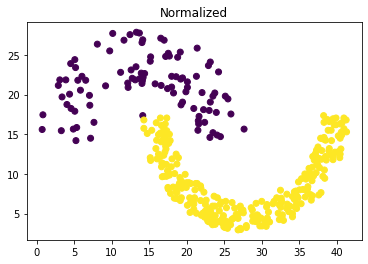

In [117]:
import pandas as pd
from src.datasets import Dataset
from src.utils import *
from src.clusterization_performance import *

dataset = Dataset('./data/jain_dataset.txt') 
X, y = dataset.X, dataset.y
df = pd.read_csv("./out/dbscan_cpp_jain_dataset.csv", header=None)
y_pred, state = df[0], df[1]
display_points(X, y_pred, 'Normalized', numerate=False)

## OUT

In [118]:
name = 'dbscan_cpp_jain_dataset_D2_R373_m14_e2_euclidean_distance'

logs = pd.read_csv(
    f'out/LOG_{name}.log',
    names=['time [ms]', 'operation', 'point_id', 'value', 'string'],
    index_col=False,
)
logs['time [ms]'] -= logs['time [ms]'].min()
logs.head()

,time [ms],operation,point_id,value,string
0,0.000000,reading_data,NaN,0.002891,NaN
1,0.685742,start log,NaN,NaN,NaN
2,0.687812,similarity_calculation,0.0,1.000000,NaN
3,0.688142,similarity_calculation,0.0,1.000000,NaN
4,0.688483,similarity_calculation,0.0,1.000000,NaN


In [119]:
import time 
import numpy as np

timer_start = time.time()
# logs = algorithm.get_logs()
mask = logs['operation'] == 'similarity_calculation'
similarity_calculation = logs[mask].groupby('point_id').sum().reset_index().drop(columns=['time [ms]'])
similarity_calculation.rename(columns={'value': '# of distance/similarity calculations'}, inplace=True)

out = pd.DataFrame({
    'point_id': np.arange(dataset.n_rows),
    'x': dataset.X[:, 0], 
    'y': dataset.X[:, 1],
    'point_type': state, # 1 - core, 0 - border, -1 - noise
    'CId': y_pred # clusters: cluster identifier or -1 in the case of noise points
})

out = out.merge(similarity_calculation, on='point_id')
out.to_csv(f'./out/OUT_{name}.csv', index=False)
saving_OUT_time = (time.time() - timer_start) * 1000
out.head()

,point_id,x,y,point_type,CId,# of distance/similarity calculations
0,0,0.85,17.45,0,-1,373.0
1,1,0.75,15.60,0,-1,373.0
2,2,3.30,15.45,0,-1,373.0
3,3,5.25,14.20,0,-1,373.0
4,4,4.90,15.65,0,-1,373.0


## STAT

In [120]:
params = {
    'epsilon': 2,
    'minPts': 14,
    'similarity': 'euclidean_distance'
}

score = evaluate(y_pred, dataset.y, dataset.X)

In [121]:
timer_stat = time.time()
stat = pd.DataFrame({
    'name of the input fil': dataset.name,
    '# of dimensions of a point': dataset.n_dimentions,
    '# of points in the input file': dataset.n_rows,
    'epsilon': params['epsilon'] if 'epsilon' in params else '',
    'minPts': params['minPts'] if 'minPts' in params else '',
    'k':  params['k'] if 'k' in params else '',
    'similarity': params['similarity'],
    'values of dimensions of a reference point': '[0,1]',
    'reading the input file [ms]': logs.loc[logs['operation'] == 'reading_data', 'value'].values[0] * 1000,
    'normalization of vectors [ms]': "",
    "Eps-neighborhood timer [ms]": logs.loc[logs['operation'] == 'Eps_time', 'value'].sum() * 1000,
    'Clustering timer [ms]': (
        logs.loc[logs['operation'] == 'stop log', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'start log', 'time [ms]'].values[0]
    ) * 1000,
    'saving results to OUT time [ms]': logs.loc[logs['operation'] == 'writing_data', 'value'].values[0] * 1000,
    "dist_to_ref_point_time [ms]": logs[logs['operation'] == 'dist_to_ref_point_time']['value'].sum() * 1000,
    'total runtime [ms]': (
        logs.loc[logs['operation'] == 'writing_data', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'reading_data', 'time [ms]'].values[0]
    ) * 1000,
    "sorting_dist_time [ms]": logs[logs['operation'] == 'sorting_pessimistic_est_time']['value'].sum() * 1000,
    "tiknn_time [ms]": logs[logs['operation'] == 'tiknn_time']['value'].sum() * 1000,
    "tirnn_time [ms]": logs[logs['operation'] == 'tirnn_time']['value'].sum() * 1000,
    '# of discovered clusters': sum(out['CId'] > -1),
    '# of discovered noise points': sum(out['point_type'] == -1),
    '# of discovered core points': sum(out['point_type'] == 1),
    '# of discovered border points': sum(out['point_type'] == 0),
    'avg # of calculations of distance/similarity': out['# of distance/similarity calculations'].mean(),
    '|TP|': score['TP'],
    '|TN|': score['TN'],
    '# of pairs of points': len(y),
    'RAND': score['rand_score'],
    'Purity': score['purity'],
    'Silhouette coefficient': score['silhouette_score_euclidean'],
    'Davies Bouldin': score['davies_bouldin_score']
}, index=['values']).T
stat_time = time.time() - timer_stat
print(stat_time)
stat.to_csv(f'./out/STAT_{name}.csv', index=False)
stat

0.1231694221496582


,values
name of the input fil,jain_dataset
# of dimensions of a point,2
# of points in the input file,373
epsilon,2
minPts,14
k,
similarity,euclidean_distance
values of dimensions of a reference point,"[0,1]"
reading the input file [ms],2.8907
normalization of vectors [ms],


## DEBUG

In [122]:
mask1 = logs['operation'] == '|Eps_neighbors|'
mask2 = logs['operation'] == 'Eps_neighbor_id'

debug1 = (
    logs[mask1]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug1.reset_index(col_level=1, inplace=True)
debug1.columns.name = None

debug2 = (
    logs[mask2]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug2.reset_index(col_level=1, inplace=True)
debug2.columns.name = None

debug = debug1.merge(debug2, on='point_id')
debug.to_csv(f'./out/DEBUG_{name}.csv', index=False)
debug.head()

,point_id,|Eps_neighbors|,Eps_neighbor_id
0,0.0,2.0,0;1;
1,1.0,2.0,0;1;
2,2.0,2.0,2;4;
3,3.0,4.0,3;4;5;14;
4,4.0,4.0,2;3;4;5;


# Flame dataset

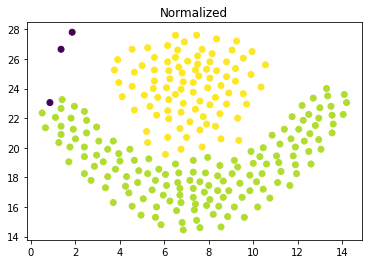

In [123]:
import pandas as pd
from src.datasets import Dataset
from src.utils import *
from src.clusterization_performance import *

dataset = Dataset('./data/flame_dataset.txt') 
X, y = dataset.X, dataset.y
df = pd.read_csv("./out/dbscan_cpp_flame_dataset.csv", header=None)
y_pred, state = df[0], df[1]
display_points(X, y_pred, 'Normalized', numerate=False)

## OUT

In [126]:
name = 'dbscan_cpp_flame_dataset_D2_R240_m23_e2.067_euclidean_distance'

logs = pd.read_csv(
    f'out/LOG_{name}.log',
    names=['time [ms]', 'operation', 'point_id', 'value', 'string'],
    index_col=False
)
logs['time [ms]'] -= logs['time [ms]'].min()
logs.head()

,time [ms],operation,point_id,value,string
0,0.000000,reading_data,NaN,0.002418,NaN
1,1.251211,start log,NaN,NaN,NaN
2,1.252711,similarity_calculation,0.0,1.000000,NaN
3,1.253005,similarity_calculation,0.0,1.000000,NaN
4,1.253387,similarity_calculation,0.0,1.000000,NaN


In [127]:
import time 
import numpy as np

timer_start = time.time()
# logs = algorithm.get_logs()
mask = logs['operation'] == 'similarity_calculation'
similarity_calculation = logs[mask].groupby('point_id').sum().reset_index().drop(columns=['time [ms]'])
similarity_calculation.rename(columns={'value': '# of distance/similarity calculations'}, inplace=True)

out = pd.DataFrame({
    'point_id': np.arange(dataset.n_rows),
    'x': dataset.X[:, 0], 
    'y': dataset.X[:, 1],
    'point_type': state, # 1 - core, 0 - border, -1 - noise
    'CId': y_pred # clusters: cluster identifier or -1 in the case of noise points
})

out = out.merge(similarity_calculation, on='point_id')
out.to_csv(f'./out/OUT_{name}.csv', index=False)
saving_OUT_time = (time.time() - timer_start) * 1000
out.head()

,point_id,x,y,point_type,CId,# of distance/similarity calculations
0,0,1.85,27.80,0,-1,240.0
1,1,1.35,26.65,0,-1,240.0
2,2,1.40,23.25,0,14,480.0
3,3,0.85,23.05,0,-1,240.0
4,4,0.50,22.35,0,14,480.0


## STAT

In [128]:
params = {
    'epsilon': 2.067,
    'minPts': 23,
    'similarity': 'euclidean_distance'
}

score = evaluate(y_pred, dataset.y, dataset.X)

In [129]:
timer_stat = time.time()
stat = pd.DataFrame({
    'name of the input fil': dataset.name,
    '# of dimensions of a point': dataset.n_dimentions,
    '# of points in the input file': dataset.n_rows,
    'epsilon': params['epsilon'] if 'epsilon' in params else '',
    'minPts': params['minPts'] if 'minPts' in params else '',
    'k':  params['k'] if 'k' in params else '',
    'similarity': params['similarity'],
    'values of dimensions of a reference point': '[0,1]',
    'reading the input file [ms]': logs.loc[logs['operation'] == 'reading_data', 'value'].values[0] * 1000,
    'normalization of vectors [ms]': "",
    "Eps-neighborhood timer [ms]": logs.loc[logs['operation'] == 'Eps_time', 'value'].sum() * 1000,
    'Clustering timer [ms]': (
        logs.loc[logs['operation'] == 'stop log', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'start log', 'time [ms]'].values[0]
    ) * 1000,
    'saving results to OUT time [ms]': logs.loc[logs['operation'] == 'writing_data', 'value'].values[0] * 1000,
    "dist_to_ref_point_time [ms]": logs[logs['operation'] == 'dist_to_ref_point_time']['value'].sum() * 1000,
    'total runtime [ms]': (
        logs.loc[logs['operation'] == 'writing_data', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'reading_data', 'time [ms]'].values[0]
    ) * 1000,
    "sorting_dist_time [ms]": logs[logs['operation'] == 'sorting_pessimistic_est_time']['value'].sum() * 1000,
    "tiknn_time [ms]": logs[logs['operation'] == 'tiknn_time']['value'].sum() * 1000,
    "tirnn_time [ms]": logs[logs['operation'] == 'tirnn_time']['value'].sum() * 1000,
    '# of discovered clusters': sum(out['CId'] > -1),
    '# of discovered noise points': sum(out['point_type'] == -1),
    '# of discovered core points': sum(out['point_type'] == 1),
    '# of discovered border points': sum(out['point_type'] == 0),
    'avg # of calculations of distance/similarity': out['# of distance/similarity calculations'].mean(),
    '|TP|': score['TP'],
    '|TN|': score['TN'],
    '# of pairs of points': len(y),
    'RAND': score['rand_score'],
    'Purity': score['purity'],
    'Silhouette coefficient': score['silhouette_score_euclidean'],
    'Davies Bouldin': score['davies_bouldin_score']
}, index=['values']).T
stat_time = time.time() - timer_stat
print(stat_time)
stat.to_csv(f'./out/STAT_{name}.csv', index=False)
stat

0.11017394065856934


,values
name of the input fil,flame_dataset
# of dimensions of a point,2
# of points in the input file,240
epsilon,2.067
minPts,23
k,
similarity,euclidean_distance
values of dimensions of a reference point,"[0,1]"
reading the input file [ms],2.4176
normalization of vectors [ms],


## DEBUG

In [130]:
mask1 = logs['operation'] == '|Eps_neighbors|'
mask2 = logs['operation'] == 'Eps_neighbor_id'

debug1 = (
    logs[mask1]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug1.reset_index(col_level=1, inplace=True)
debug1.columns.name = None

debug2 = (
    logs[mask2]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug2.reset_index(col_level=1, inplace=True)
debug2.columns.name = None

debug = debug1.merge(debug2, on='point_id')
debug.to_csv(f'./out/DEBUG_{name}.csv', index=False)
debug.head()

,point_id,|Eps_neighbors|,Eps_neighbor_id
0,0.0,2.0,0;1;
1,1.0,2.0,0;1;
2,2.0,12.0,2;3;4;5;6;7;8;9;10;11;13;14; 2;3;4;5;6;7;8;9;1...
3,3.0,11.0,2;3;4;5;6;7;8;9;10;11;14;
4,4.0,13.0,2;3;4;5;6;7;8;9;10;11;13;14;15; 2;3;4;5;6;7;8;...


# R15 dataset

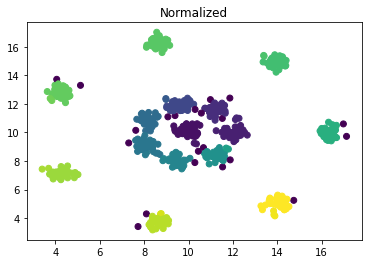

In [131]:
import pandas as pd
from src.datasets import Dataset
from src.utils import *
from src.clusterization_performance import *

dataset = Dataset('./data/R15_dataset.txt') 
X, y = dataset.X, dataset.y
df = pd.read_csv("./out/dbscan_cpp_R15_dataset.csv", header=None)
y_pred, state = df[0], df[1]
display_points(X, y_pred, 'Normalized', numerate=False)

## OUT

In [132]:
name = 'dbscan_cpp_R15_dataset_D2_R600_m2_e0.3_euclidean_distance'

logs = pd.read_csv(
    f'out/LOG_{name}.log',
    names=['time [ms]', 'operation', 'point_id', 'value', 'string'],
    index_col=False
)
logs['time [ms]'] -= logs['time [ms]'].min()
logs.head()

,time [ms],operation,point_id,value,string
0,0.000000,reading_data,NaN,0.003191,NaN
1,0.750684,start log,NaN,NaN,NaN
2,0.753904,similarity_calculation,0.0,1.000000,NaN
3,0.754365,similarity_calculation,0.0,1.000000,NaN
4,0.754842,similarity_calculation,0.0,1.000000,NaN


In [133]:
import time 
import numpy as np

timer_start = time.time()
# logs = algorithm.get_logs()
mask = logs['operation'] == 'similarity_calculation'
similarity_calculation = logs[mask].groupby('point_id').sum().reset_index().drop(columns=['time [ms]'])
similarity_calculation.rename(columns={'value': '# of distance/similarity calculations'}, inplace=True)

out = pd.DataFrame({
    'point_id': np.arange(dataset.n_rows),
    'x': dataset.X[:, 0], 
    'y': dataset.X[:, 1],
    'point_type': state, # 1 - core, 0 - border, -1 - noise
    'CId': y_pred # clusters: cluster identifier or -1 in the case of noise points
})

out = out.merge(similarity_calculation, on='point_id')
out.to_csv(f'./out/OUT_{name}.csv', index=False)
saving_OUT_time = (time.time() - timer_start) * 1000
out.head()

,point_id,x,y,point_type,CId,# of distance/similarity calculations
0,0,9.802,10.132,1,1,600.0
1,1,10.350,9.768,1,1,600.0
2,2,10.098,9.988,1,1,600.0
3,3,9.730,9.910,1,1,600.0
4,4,9.754,10.430,1,1,600.0


## STAT

In [134]:
params = {
    'epsilon': 0.3,
    'minPts': 2,
    'similarity': 'euclidean_distance'
}

score = evaluate(y_pred, dataset.y, dataset.X)

In [135]:
timer_stat = time.time()
stat = pd.DataFrame({
    'name of the input fil': dataset.name,
    '# of dimensions of a point': dataset.n_dimentions,
    '# of points in the input file': dataset.n_rows,
    'epsilon': params['epsilon'] if 'epsilon' in params else '',
    'minPts': params['minPts'] if 'minPts' in params else '',
    'k':  params['k'] if 'k' in params else '',
    'similarity': params['similarity'],
    'values of dimensions of a reference point': '[0,1]',
    'reading the input file [ms]': logs.loc[logs['operation'] == 'reading_data', 'value'].values[0] * 1000,
    'normalization of vectors [ms]': "",
    "Eps-neighborhood timer [ms]": logs.loc[logs['operation'] == 'Eps_time', 'value'].sum() * 1000,
    'Clustering timer [ms]': (
        logs.loc[logs['operation'] == 'stop log', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'start log', 'time [ms]'].values[0]
    ) * 1000,
    'saving results to OUT time [ms]': logs.loc[logs['operation'] == 'writing_data', 'value'].values[0] * 1000,
    "dist_to_ref_point_time [ms]": logs[logs['operation'] == 'dist_to_ref_point_time']['value'].sum() * 1000,
    'total runtime [ms]': (
        logs.loc[logs['operation'] == 'writing_data', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'reading_data', 'time [ms]'].values[0]
    ) * 1000,
    "sorting_dist_time [ms]": logs[logs['operation'] == 'sorting_pessimistic_est_time']['value'].sum() * 1000,
    "tiknn_time [ms]": logs[logs['operation'] == 'tiknn_time']['value'].sum() * 1000,
    "tirnn_time [ms]": logs[logs['operation'] == 'tirnn_time']['value'].sum() * 1000,
    '# of discovered clusters': sum(out['CId'] > -1),
    '# of discovered noise points': sum(out['point_type'] == -1),
    '# of discovered core points': sum(out['point_type'] == 1),
    '# of discovered border points': sum(out['point_type'] == 0),
    'avg # of calculations of distance/similarity': out['# of distance/similarity calculations'].mean(),
    '|TP|': score['TP'],
    '|TN|': score['TN'],
    '# of pairs of points': len(y),
    'RAND': score['rand_score'],
    'Purity': score['purity'],
    'Silhouette coefficient': score['silhouette_score_euclidean'],
    'Davies Bouldin': score['davies_bouldin_score']
}, index=['values']).T
stat_time = time.time() - timer_stat
print(stat_time)
stat.to_csv(f'./out/STAT_{name}.csv', index=False)
stat

0.1646432876586914


,values
name of the input fil,R15_dataset
# of dimensions of a point,2
# of points in the input file,600
epsilon,0.3
minPts,2
k,
similarity,euclidean_distance
values of dimensions of a reference point,"[0,1]"
reading the input file [ms],3.1906
normalization of vectors [ms],


## DEBUG

In [136]:
mask1 = logs['operation'] == '|Eps_neighbors|'
mask2 = logs['operation'] == 'Eps_neighbor_id'

debug1 = (
    logs[mask1]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug1.reset_index(col_level=1, inplace=True)
debug1.columns.name = None

debug2 = (
    logs[mask2]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug2.reset_index(col_level=1, inplace=True)
debug2.columns.name = None

debug = debug1.merge(debug2, on='point_id')
debug.to_csv(f'./out/DEBUG_{name}.csv', index=False)
debug.head()

,point_id,|Eps_neighbors|,Eps_neighbor_id
0,0.0,12.0,0;3;5;11;12;18;21;25;30;33;35;36;
1,1.0,12.0,1;6;8;14;16;17;19;27;29;31;32;38;
2,2.0,15.0,2;5;6;8;14;16;17;18;19;30;31;32;35;36;38;
3,3.0,8.0,0;3;5;7;13;21;35;36;
4,4.0,8.0,4;11;12;22;25;30;33;37;
